In [16]:
"""
Graph Model package to implement and vizualize green growth models

ROADMAP:
- Add a concatenate function to properly concatenate models without duplicates OK !
- Automatically parse the computation to avoid having to type the name OK !

- Cleanup the parser TODO
- Rewrite parser and drawer as function rather than objects TODO
- Add on pip for easier use by the team + clean github repo
"""
__author__ = 'Simon'

import networkx as nx
import graphviz
import logging
import numpy as np
import pandas as pd
from functools import partial, reduce
import inspect
import copy


logging.basicConfig(filename='example.log', level=logging.DEBUG)

draw_properties = {
    'fillcolor': {'input': '#e76f51',
                  'parameter': '#e9c46a',
                  'variable': '#f4a261',
                  'output': '#2a9d8f',
                  'computationnal': '#e76f51'},
    'fontcolor': {'input': '#eeeeee',
                  'parameter': '#eeeeee',
                  'variable': '#eeeeee',
                  'output': '#eeeeee',
                  'computationnal': '#000000'},
    'color': {'input': '#eeeeee',
              'parameter': '#eeeeee',
              'variable': '#eeeeee',
              'output': '#eeeeee',
              'computationnal': '#A9A9A9'},
    'style': {'input': 'filled',
              'parameter': 'filled',
              'variable': 'filled',
              'output': 'filled',
              'computationnal': ''},
}


class GraphModel(nx.DiGraph):
    '''GraphModel allows to write a model as a Graph.

    It herites from nx.Digraph class.

    Attributes:
        node_ordering (list): Topological order of the computationnal nodes.
    '''

    def __init__(self, graph_specifications):
        '''Initialize a graph from a specification.

        Args:
            graph_specifications(dict): dict of node specification.
        '''
        super(GraphModel, self).__init__()
        self.make_graph(graph_specifications)
        self.node_ordering = self.get_computational_nodes_ordering()
        self.model_function = model_function(self)

    def checks(self, nodes, edges):
        '''Checks if the graph is well defined.

        Args:
            nodes (List): list of nodes.
            edges (List): list of edges.
        '''
        node_set = set([n[0] for n in nodes])
        edge_set = set([e[0] for e in edges])
        diff = edge_set - node_set
        assert edge_set <= node_set, f"{diff} is used in a computation but is not defined in a node"

    def make_graph(self, graph_nodes):
        '''Make the nx.Digraph object.

        Args:
            graph_nodes(List): list of formatted nodes

        Returns:
            None, Initialize the graph object.
        '''
        nodes, edges, summary_df = GraphParser().parse(graph_nodes)
        self.checks(nodes, edges)
        self.add_nodes_from(nodes)
        self.add_edges_from(edges)
        self.summary_df = summary_df # a bit clunky to put it here
        return None

    def get_node_by_type(self, node_type):
        '''Returns the nodes of a given node_type'''
        return [node_id for node_id, node in self.nodes.items() if node['type'] == node_type]

    def inputs_(self):
        return self.get_node_by_type('input')

    def outputs_(self):
        return self.get_node_by_type('output')

    def variables_(self):
        return self.get_node_by_type('variable')

    def parameters_(self):
        return self.get_node_by_type('parameter')

    def get_computational_nodes_ordering(self):
        '''Returns the sorted list of computationnal nodes.

        Returns:
            ordering(list): List of ordered computationnal nodes.
        '''
        ordering = [node for node in nx.topological_sort(self) if '_comp' in node]
        return ordering

    def run(self, X):
        '''Run the GraphModel given inputs and parameters.

        Args:
            X(dict): dictionnary of input and parameters.

        Returns:
            X(dict): inputs, variables and outputs of the graph.
        '''
        X = self.model_function(X)
        
        return X

    def draw(self, draw_properties=draw_properties):
        '''Draw the graph.

        Args:
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        return GraphDrawer(draw_properties).draw(self)

    def draw_computation(self, inputs_parameters, draw_properties=draw_properties):
        '''Draw the graph with the computated values.

        Args:
            draw_properties(dict): dictionnary of properties for the graph plot.
            inputs(dict): dictionnary of input values.
            parameters(dict): dictionnary of parameter values.
        '''
        return GraphDrawer(draw_properties).draw_computation(self, inputs_parameters)


class GraphDrawer():
    '''A class to draw the Graph models.

    Attributes:
        draw_properties(dict): dictionnary of properties for the graph plot.
    '''

    def __init__(self, draw_properties):
        '''Initialize the GraphDrawer

        Attributes:
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        self.draw_properties = draw_properties
        return None

    def get_node_label(self, node):
        '''Get the label of a given node.

        TO CLEAN UP !!!

        Args:
            node(node): Node of the graph.

        Returns:
            label(str): A label for the node.
        '''
        node_id, label, node_type = node[0], node[1]['name'], node[1]['type']

        if node_type != 'computationnal':
            label = f"{label} \n ({node_id})"
            if 'value' in node[1]:
                value = node[1]['value']
                label = f"{label} \n {value}"
            if 'unit' in node[1]:
                unit = node[1]['unit']
                label = f"{label} \n {unit}"
        return label

    def draw_node(self, dot, node, draw_properties):
        '''Draw a node of the graph.

        TO CLEAN UP !!!

        Args:
            dot(dot): dot object for drawing.
            node(node): Node of the graph.
            draw_properties(dict): dictionnary of properties for the graph plot.

        Returns:
            None, updates the dot object.
        '''
        label = self.get_node_label(node)
        node_type = node[1]['type']
        dot.node(node[0], node[0], {"shape": "rectangle",
                                    "peripheries": "1",
                                    'label': label,
                                    'fillcolor': draw_properties['fillcolor'][node_type],
                                    'style': draw_properties['style'][node_type],
                                    'color': draw_properties['color'][node_type],
                                    'fontcolor': draw_properties['fontcolor'][node_type],
                                    'fontname': 'roboto'
                                    }
                 )

    def draw_edge(self, dot, a, b, draw_properties):
        '''Draw an edge of the graph.

        Args:
            dot(dot): dot object for drawing.
            a(node): Node of the graph.
            b(node): Node of the graph.
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        dot.edge(a, b, color='#A9A9A9')

    def draw(self, G):
        '''Draw a full Graph Model

        Args:
            G(GraphModel): A graph model.

        Returns:
            dot(obj): The plot object of the graph.
        '''
        draw_properties = self.draw_properties
        dot = graphviz.Digraph(graph_attr={'splines': 'ortho'})
        for node in G.nodes(data=True):
            self.draw_node(dot, node, draw_properties)
        for a, b in G.edges:
            self.draw_edge(dot, a, b, draw_properties)
        return dot

    def draw_computation(self, G, inputs_parameters):
        '''Draw a full Graph Model with the computed values:

        Args:
            G(GraphModel): A graph model.
            inputs(dict): dictionnary of input values.
            parameters(dict): dictionnary of parameter values.

        Returns:
            dot(obj): The plot object of the graph.
        '''
        X = G.run(inputs_parameters)
        for node_id in X:
            G.nodes[node_id]['value'] = X[node_id]
        dot = self.draw(G)

        for node_id in X:  # Ugly, need to find better option for drawing
            del G.nodes[node_id]['value']

        return dot


class GraphParser():
    '''A class to parse the specification of a graph
    '''

    def __init__(self):
        '''
        Initialize a parser.
        '''
        return None
    
    def format_node(self, node):
        if 'computation' in node:
            formula = node['computation']
            computation_name = inspect.getsource(formula).split('**kwargs:')[-1].strip().strip('}')
            node['computation'] = {'formula': formula, 'name':computation_name}
            node['in'] = inspect.getfullargspec(formula).args

            return node

        else:
            return node

    def parse_node(self, raw_node):
        '''Parse a node.

        Args:
            raw_node(dict): raw node given in graph_specifications.

        Returns:
            node(node): A formatted non computationnal node.
        '''
        node = (raw_node['id'], {k: raw_node[k] for k in ('type', 'unit', 'name')})
        return node

    def parse_computational_node(self, raw_node):
        '''Parse a computationnal node.

        Args:
            raw_node(dict): raw node given in graph_specifications.

        Returns:
            node(node): A formatted computationnal node
        '''
        node_id = f"{raw_node['id']}_comp"
        node_param = {}
        node_param['formula'] = raw_node['computation']['formula']
        node_param['name'] = raw_node['computation']['name'] 
        node_param['out'] = raw_node['id']
        node_param['in'] = raw_node['in']
        node_param['type'] = 'computationnal'
        
        node = (node_id, node_param)
        
        return node

    def parse_computational_edges(self, comp_node):
        '''Parse edges from and to a computationnal node.

        Args:
            comp_node(dict): a computationnal node.

        Returns:
            edges(list): list of edges in the graph.
        '''
        edges = []
        for in_node in comp_node[1]['in']:
            edge = (in_node, comp_node[0])
            edges.append(edge)
        edges.append((comp_node[0], comp_node[0].split('_comp')[0]))
        return edges

    def parse(self, graph_specifications):
        '''Parse the graph specification

        Args:
            graph_specifications(dict): dict of nodes

        Returns:
            nodes(List): list of parsed nodes.
            egdes(List): list of parsed edges.
            summary_df(pd.DataFrame): DataFrame summarizing the graph
        '''
        
        graph_specifications = copy.deepcopy(graph_specifications)
        
        edges, nodes = [], []
        
        for node_id, raw_node in graph_specifications.items():
            raw_node['id'] = node_id
            
            raw_node = self.format_node(raw_node) # formats the node to match the previous framework.
            
            node = self.parse_node(raw_node)
            
            nodes.append(node)

            if 'computation' in raw_node:
                node = self.parse_computational_node(raw_node)
                nodes.append(node)

                comp_edges = self.parse_computational_edges(node)
                edges += comp_edges

        return nodes, edges, self.summary(graph_specifications)
    
    
    def summary(self, graph_specifications):
        '''Return a pandas dataframe to summarize the node of the graph as specified in the graph_specification.

        TO IMPROVE.
        '''
        summary_df = pd.DataFrame()

        for node_id, node in graph_specifications.items():
            
            node['id'] = node_id

            if 'computation' in node:
                comp = node['computation']['name']
            else:
                comp = np.nan

            row = pd.DataFrame({'name': node['name'], 'type': node['type'],
                                'unit': node['unit'], 'computation': comp}, index=[node['id']])
            summary_df = summary_df.append(row)

        summary_df.index.name = 'id'
        
        return summary_df


# Function composition
def compose(*functions):
    return reduce(lambda f, g: lambda x: f(g(X=x)), functions, lambda x: x)


def node_function(node, X):
    X = X.copy()
    function, out_node = node['formula'], node['out']
    X[out_node] = function(**X)
    return X


def model_function(G):
    '''The function computed by the model'''
    functions_list = [partial(node_function, node=G.nodes[node_id])
                      for node_id in G.node_ordering[::-1]]
    return compose(*functions_list)


# Node merging
def get_duplicated_nodes(id_type_df):
    duplicated_nodes = (id_type_df.groupby('id').count()>1)
    duplicated_nodes = duplicated_nodes[duplicated_nodes.type].index
    return duplicated_nodes

def get_id_type_df(list_of_graph_specs):
    id_type_df = [[(d, node['type']) for d,node in graph_spec.items()] for graph_spec in list_of_graph_specs]
    id_type_df =  pd.DataFrame(sum(id_type_df, []), columns=['id', 'type'])
    return id_type_df

def merge_nodes(nodes_to_merge):
    if 'computation' in nodes_to_merge.columns:
        pass
        nodes_to_merge.dropna()        
        computation = nodes_to_merge.dropna(subset=['computation']).computation.unique()[0]
        unit = nodes_to_merge.unit.unique()[0]
        name = nodes_to_merge.name.unique()[0]
        return {'name': name, 'type': 'variable', 'unit': unit, 'computation': computation}
    else:
        return nodes_to_merge.drop_duplicates().to_dict(orient='records')[0]     
    

def concatenate_graph_specs(list_of_graph_specs):
    '''Concatenate a list of graph specifications.
    
    - Duplicated nodes are removed.
    - Nodes that are inputs in some and outputs in other becomes variables.
    '''
    id_type_df = get_id_type_df(list_of_graph_specs)
    
    duplicated_nodes = get_duplicated_nodes(id_type_df)
    
    merged_nodes = {}
    
    for node_id in duplicated_nodes:
        nodes_to_merge = pd.DataFrame([nodes[node_id] for nodes in list_of_graph_specs])
        
        # Sanity check to make sure graphs are consistent
        assert nodes_to_merge[['unit', 'name']].drop_duplicates().shape[0] == 1, f'{node_id} has different name or unit across specifications'
        
        merged_nodes[node_id] = merge_nodes(nodes_to_merge)

        
    concatenated_specs = {}
    for graph_specs in list_of_graph_specs:
        concatenated_specs.update(graph_specs)
    concatenated_specs.update(merged_nodes)
        
    return concatenated_specs

{'In_1': 5, 'In_2': 4, 'Par_1': 3, 'Par_2': 5, 'Par_3': 5, 'Var_2': 1.25, 'Var_1': 15, 'Out_1': 21.25}


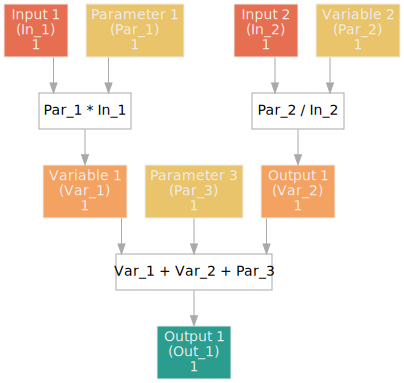

In [25]:
graph_specifications = {
    'In_1': {'type': 'input',
             'unit': '1',
             'name': 'Input 1'},
    'Par_1': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 1'},
    'Var_1': {'type': 'variable',
              'name': 'Variable 1',
              'unit': '1',
              'computation': lambda Par_1, In_1, **kwargs: Par_1 * In_1
              },
    'Par_3': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 3'},
    'Out_1': {'type': 'output',
              'name': 'Output 1',
              'unit': '1',
              'computation': lambda Var_1, Var_2, Par_3, **kwargs: Var_1 + Var_2 + Par_3
              },
    'In_2': {'type': 'input',
             'unit': '1',
             'name': 'Input 2'},
    'Par_2': {'type': 'parameter',
              'unit': '1',
              'name': 'Variable 2'},
    'Var_2': {'type': 'variable',
              'name': 'Output 1',
              'unit': '1',
              'computation': lambda In_2, Par_2, **kwargs: Par_2 / In_2
             }
}

inputs_parameters = {
    'In_1': 5,
    'In_2': 4,
    'Par_1': 3,
    'Par_2': 5,
    'Par_3': 5
}

Model = GraphModel(graph_specifications)

print(Model.run(inputs_parameters))

Model.draw()

In [23]:
inputs_parameters = {
    'In_1': 5,
    'In_2': 4,
    'Par_1': 3,
    'Par_2': 5,
    'Par_3': 5
}


graph_specifications_0 = {
    'In_1': {'type': 'input',
             'unit': '1',
             'name': 'Input 1'},
    'Par_1': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 1'},
    'Var_1': {'type': 'variable',
              'name': 'Variable 1',
              'unit': '1',
              'computation': lambda Par_1, In_1, **kwargs: Par_1 * In_1
              },
    'Par_3': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 3'},
    'Out_1': {'type': 'output',
              'name': 'Output 1',
              'unit': '1',
              'computation': lambda Var_1, Var_2, Par_3, **kwargs: Var_1 + Var_2 + Par_3
              },
    'In_2': {'type': 'input',
             'unit': '1',
             'name': 'Input 2'},
    'Par_2': {'type': 'parameter',
              'unit': '1',
              'name': 'Variable 2'},
    'Var_2': {'type': 'variable',
              'name': 'Output 1',
              'unit': '1',
              'computation': lambda In_2, Par_2, **kwargs: Par_2 / In_2}
}


Model = GraphModel(graph_specifications_0)

results = Model.run(inputs_parameters)

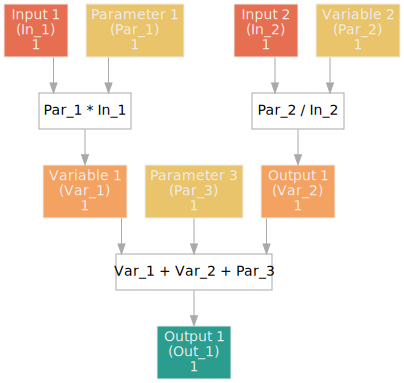

In [24]:
Model.draw()

In [21]:
graph_specifications_0 = {
    'In_1': {'type': 'input',
             'unit': '1',
             'name': 'Input 1'},
    'Par_1': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 1'},
    'Var_1': {'type': 'variable',
              'name': 'Variable 1',
              'unit': '1',
              'computation': lambda Par_1, In_1, **kwargs: Par_1 * In_1
              },
    'Par_3': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 3'},
    'Out_1': {'type': 'output',
              'name': 'Intermediate Output 1',
              'unit': '1',
              'computation': lambda Var_1, Var_2, Par_3, **kwargs: Var_1 + Var_2 + Par_3
              },
    'In_2': {'type': 'input',
             'unit': '1',
             'name': 'Input 2'},
    'Par_2': {'type': 'parameter',
              'unit': '1',
              'name': 'Variable 2'},
    'Var_2': {'type': 'variable',
              'name': 'Output 1',
              'unit': '1',
              'computation': lambda In_2, Par_2, **kwargs: Par_2 / In_2
             }
}

graph_specifications_1 = {
    'Out_1': {'type': 'input',
              'unit': '1',
              'name': 'Intermediate Output 1'},
    'Par_a': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter a'},
    'Var_a': {'type': 'variable',
              'name': 'Variable a',
              'unit': '1',
              'computation': lambda Out_1, Par_a, **kwargs: Out_1 * Par_a
              },
    'Par_b': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter b'},
    'Par_1': {'type': 'parameter',
              'unit': '1',
              'name': 'Parameter 1'},
    'Out_2': {'type': 'output',
              'name': 'Output 2',
              'unit': '1',
              'computation': lambda Par_b, Var_a, Par_1, **kwargs: Var_a * Par_b * Par_1
              },

}


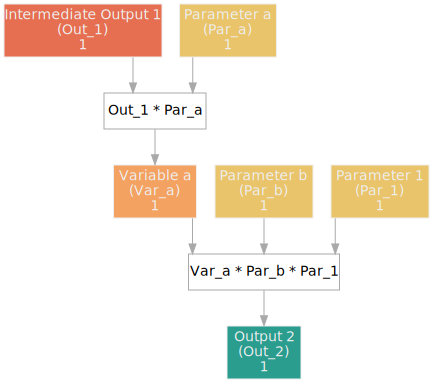

In [22]:
GraphModel(graph_specifications_1).draw()

In [23]:
concatenated_model = GraphModel(concatenate_graph_specs([graph_specifications_1, graph_specifications_0]))

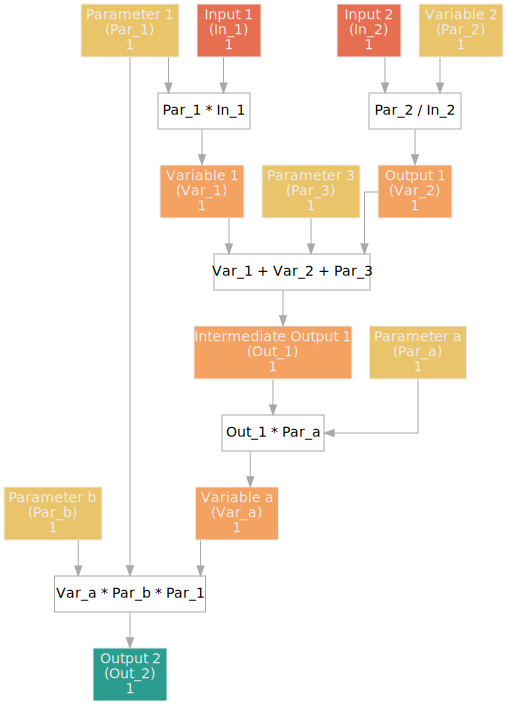

In [24]:
concatenated_model.draw()

In [25]:
inputs_parameters = {
    'In_1': 5,
    'In_2': 4,
    'Par_1': 3,
    'Par_2': 5,
    'Par_3': 5,
    'Par_a': 1,
    'Par_b': -2
}

concatenated_model.run(inputs_parameters)

{'In_1': 5,
 'In_2': 4,
 'Par_1': 3,
 'Par_2': 5,
 'Par_3': 5,
 'Par_a': 1,
 'Par_b': -2,
 'Var_2': 1.25,
 'Var_1': 15,
 'Out_1': 21.25,
 'Var_a': 21.25,
 'Out_2': -127.5}

In [26]:
concatenated_model.summary_df

,name,type,unit,computation
id,,,,
Out_1,Intermediate Output 1,variable,1,Var_1 + Var_2 + Par_3
Par_a,Parameter a,parameter,1,NaN
Var_a,Variable a,variable,1,Out_1 * Par_a
Par_b,Parameter b,parameter,1,NaN
Par_1,Parameter 1,parameter,1,NaN
Out_2,Output 2,output,1,Var_a * Par_b * Par_1
In_1,Input 1,input,1,NaN
Var_1,Variable 1,variable,1,Par_1 * In_1
Par_3,Parameter 3,parameter,1,NaN
